# Localization Model

## Import Libraries and Data

In [1050]:
import time 
import pickle

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

from matplotlib.colors import Normalize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

In [1051]:
path = 'Data/ui_data_2.csv'  
data = pd.read_csv(path)
print(data.shape)

(6596, 10)


## Pre-Checks

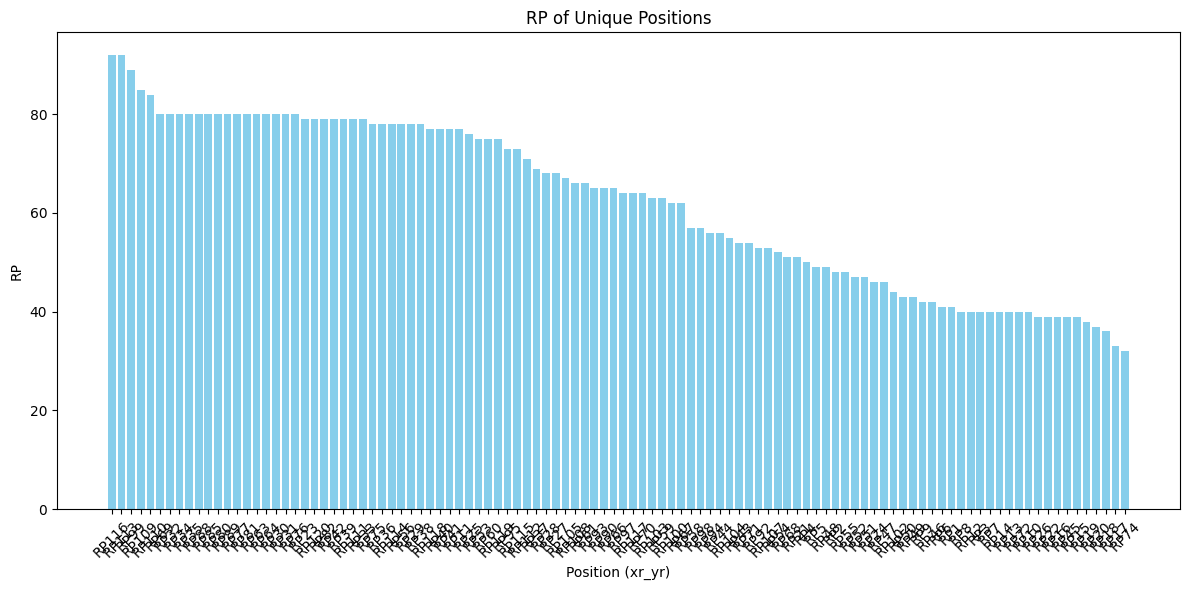

In [1052]:
# Step 2: Count the frequency of each unique position
frequency = data['reference_point'].value_counts()

# If you want to reset the index and get a DataFrame
frequency_df = frequency.reset_index()
frequency_df.columns = ['reference_point', 'frequency']

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(frequency_df['reference_point'], frequency_df['frequency'], color='skyblue')
plt.xlabel('Position (xr_yr)')
plt.ylabel('RP')
plt.title('RP of Unique Positions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [1053]:
data['rssi_ap_dosen'].unique()

array([  nan,  -96.,  -94.,  -95.,  -92.,  -97.,  -90.,  -89.,  -91.,
        -93.,  -86.,  -88.,  -87.,  -81.,  -82.,  -83.,  -84.,  -85.,
        -79.,  -80.,  -78.,  -77.,  -75.,  -70.,  -71.,  -72.,  -73.,
        -74.,  -63.,  -64.,  -62.,  -76.,  -98.,  -99., -100.,  -69.,
        -66.,  -67.,  -65.,  -68.,  -37.,  -41.,  -40.,  -36.,  -38.,
        -35.,  -39.,  -43.,  -42.,  -44.,  -47.,  -45.])

In [1054]:
data['rssi_ap_digilab'].unique()

array([-64., -63., -65., -62., -61., -60., -67., -71.,  nan, -70., -66.,
       -68., -69., -74., -75., -72., -73., -59., -57., -58., -43., -42.,
       -44., -45., -41., -39., -50., -51., -46., -47., -52., -53., -54.,
       -55., -56., -76., -77., -81., -80., -79., -78., -49., -48., -83.,
       -82., -86., -87., -84., -85., -89., -88., -90., -91., -34., -36.,
       -37., -40., -38., -35.])

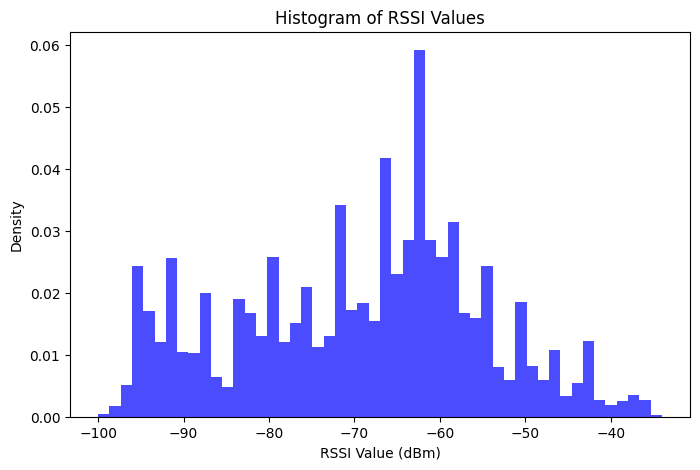

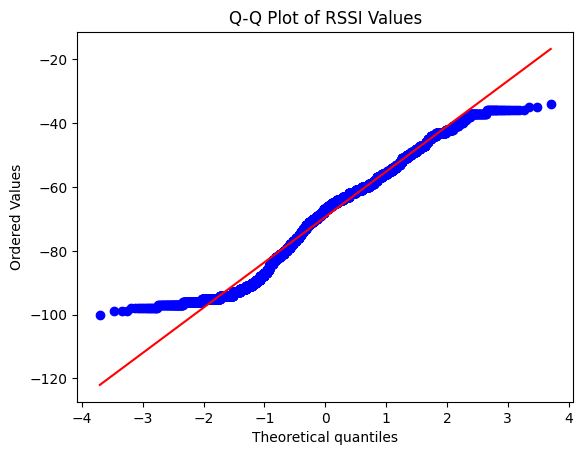

RSSI Skewness: -0.1302
RSSI Kurtosis: -0.6852


In [1055]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import skew, kurtosis

# Select RSSI columns (replace with actual column names from your dataset)
rssi_digilab = data["rssi_ap_digilab"]
rssi_dosen = data["rssi_ap_dosen"]

rssi_digilab = rssi_digilab[rssi_digilab > -200]
rssi_dosen = rssi_dosen[rssi_dosen > -200]

# Combine both RSSI columns for analysis
rssi_values = np.concatenate([rssi_digilab, rssi_dosen])

# 1️⃣ Histogram (Check RSSI Distribution)
plt.figure(figsize=(8, 5))
plt.hist(rssi_values, bins=50, color='blue', alpha=0.7, density=True)
plt.xlabel("RSSI Value (dBm)")
plt.ylabel("Density")
plt.title("Histogram of RSSI Values")
plt.show()

# 2️⃣ Q-Q Plot (Check for Normality)
stats.probplot(rssi_values, dist="norm", plot=plt)
plt.title("Q-Q Plot of RSSI Values")
plt.show()

# 3️⃣ Skewness & Kurtosis (Numerical Analysis)
rssi_skewness = skew(rssi_values)
rssi_kurtosis = kurtosis(rssi_values)

print(f"RSSI Skewness: {rssi_skewness:.4f}")  # >0 means right-skewed, <0 means left-skewed
print(f"RSSI Kurtosis: {rssi_kurtosis:.4f}")  # >3 means heavy-tailed (outliers)


## Handling Missing Values (NaN)

In [1056]:
# Fill missing RSSI values
data['rssi_ap_digilab'] = data['rssi_ap_digilab'].fillna(-200)
data['rssi_ap_dosen'] = data['rssi_ap_dosen'].fillna(-200)

## Real AP Coordinates

In [1057]:
ap_coordinates = {
    'DTE Staff (Digilab)': (867, 1122),
    'DTE Staff (Dosen)': (2454, 520)
}

## Relative Position Column Insertion

In [1058]:
data = data[~data['reference_point'].isin(['RP49', 'RP74'])]

# Ensure the relative_position column exists with a default numeric value (-1 for unassigned)
data['relative_position'] = -1  # Using -1 to indicate unassigned values initially

# Define reference points that should be assigned a relative position of 0
zero_rps = (
    list(range(1, 21)) +   # RP1-20
    list(range(53, 57)) +  # RP53-56
    list(range(58, 62)) +  # RP58-61
    list(range(63, 65)) +  # RP63-64
    list(range(66, 73)) +  # RP66-72
    list(range(75, 78)) +  # RP75-77
    list(range(80, 89)) +  # RP80-88
    list(range(113, 116)) +  # RP113-115
    list(range(118, 121)) +  # RP118-120
    list(range(93, 96)) +
    list(range(98, 101)) +
    list(range(103, 106)) +
    list(range(108, 111)) 
)

# Define reference points that should be assigned a relative position of 1
one_rps = list(range(28, 43)) + [89, 90]  # RP28-42 and RP89-90


# Convert lists to sets for faster lookup
zero_rp_set = {f'RP{i}' for i in zero_rps}
one_rp_set = {f'RP{i}' for i in one_rps}

# Apply conditions to assign relative_position
data['relative_position'] = data['reference_point'].apply(
    lambda rp: 0 if rp in zero_rp_set else (1 if rp in one_rp_set else -1)
)

# Convert to integer type to ensure it's numeric
data['relative_position'] = data['relative_position'].astype(int)

# Check unique values to ensure no -1 remains
print("Unique values in relative_position:", data['relative_position'].unique())

# Check the first few rows to confirm the relative_position column was added correctly
print(data[['reference_point', 'relative_position']].head())

Unique values in relative_position: [ 0  1 -1]
  reference_point  relative_position
0             RP1                  0
1             RP1                  0
2             RP1                  0
3             RP1                  0
4             RP1                  0


In [1059]:
# Convert the 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])
# Convert to seconds since the epoch
data['time_numeric'] = data['time'].apply(lambda x: x.time())

## BSSID Mapping (Encoding)

In [1060]:
# Define the mapping dictionary
bssid_mapping = {
    '70:a7:41:dc:8e:55': 1,
    '72:a7:41:9c:8e:55': 2,
    '70:a7:41:dc:77:cd': 3,
    '72:a7:41:9c:77:cd': 4
}

In [1061]:
data['bssid'] = data['bssid'].map(bssid_mapping)
print(data[['bssid', 'bssid']].head())


   bssid  bssid
0      4      4
1      3      3
2      4      4
3      4      4
4      3      3


In [1062]:
# Assuming 'reference_point' is your column name in the DataFrame
data['reference_point'] = data['reference_point'].str.replace('RP', '').astype(int)

# Check the result
print(data['reference_point'])

0         1
1         1
2         1
3         1
4         1
       ... 
6591    116
6592    116
6593    116
6594    116
6595    116
Name: reference_point, Length: 6521, dtype: int32


In [1063]:
data.sample(10)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric
3033,2025-03-01 01:59:27.335825500+00:00,81,2,DTE Staff,1,11,2000,639,-200.0,-77.0,0,01:59:27.335825
2630,2025-03-01 00:54:50.339890600+00:00,58,13,DTE Student,4,1,1653,1368,-69.0,-200.0,0,00:54:50.339890
4947,2025-03-03 08:24:48.300412700+00:00,99,13,DTE Student,4,6,720,639,-60.0,-200.0,0,08:24:48.300412
1514,2024-10-23 07:48:40.296645800+00:00,39,13,DTE Student,4,11,2224,1037,-61.0,-200.0,1,07:48:40.296645
3652,2025-03-01 03:35:24.305702900+00:00,63,10,DTE Staff,1,11,1826,1368,-200.0,-80.0,0,03:35:24.305702
3046,2025-03-01 02:00:59.104510+00:00,81,6,DTE Staff,3,1,2000,639,-60.0,-200.0,0,02:00:59.104510
4423,2025-03-03 07:11:51.092943800+00:00,110,18,DTE Student,4,6,1120,838,-40.0,-200.0,0,07:11:51.092943
5350,2025-03-11 07:38:23.544969100+00:00,51,3,DTE Staff,3,6,1341,1948,-62.0,-200.0,-1,07:38:23.544969
5575,2025-03-11 08:26:07.058083500+00:00,25,18,DTE Staff,3,6,529,1037,-58.0,-200.0,-1,08:26:07.058083
5668,2025-03-11 08:48:41.882742900+00:00,21,3,DTE Staff,3,6,70,1037,-54.0,-200.0,-1,08:48:41.882742


In [1064]:
# # Save the final dataframe
# data.to_csv('data_preprocessed.csv', index=False)
# print(f"Data saved to {'data_preprocessed.csv'}")

## Encoder (Still Template)

In [1065]:
# def encode_and_save_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
#     # Initialize the LabelEncoder
#     le = LabelEncoder()
    
#     # Fit and transform the data
#     encoded_values = le.fit_transform(data[column_name])
    
#     # Replace the original column with encoded values
#     data[column_name] = encoded_values
    
#     # Save the encoder to a file
#     with open(encoder_file_name, 'wb') as file:
#         pickle.dump(le, file)
    
#     print(f"Encoded {column_name} and saved encoder to {encoder_file_name}")
    
#     return data

# def decode_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
#     # Load the encoder from the file
#     with open(encoder_file_name, 'rb') as file:
#         le = pickle.load(file)
    
#     # Transform the encoded values back to original labels
#     decoded_values = le.inverse_transform(data[column_name])
    
#     # Replace the encoded column with decoded values
#     data[column_name] = decoded_values
    
#     print(f"Decoded {column_name} using encoder from {encoder_file_name}")
    
#     return data

# def decode_predictions(y_pred, encoder_file_name='label_encoder.pkl'):
#     # Load the encoder from the file
#     with open(encoder_file_name, 'rb') as file:
#         le = pickle.load(file)
    
#     # Transform the encoded predictions back to original labels
#     decoded_predictions = le.inverse_transform(y_pred)
    
#     print(f"Decoded predictions using encoder from {encoder_file_name}")
    
#     return decoded_predictions

## Handling Overlapping Data


In [1066]:
print("Columns in DataFrame:", data.columns)
print("Shape of DataFrame:", data.shape)

Columns in DataFrame: Index(['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel',
       'xr', 'yr', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position',
       'time_numeric'],
      dtype='object')
Shape of DataFrame: (6521, 12)


In [1067]:
df = data.iloc[:, [1, 2, 4, 5, 8 , 9, 10]]
print("\nColumns in X:", df.columns.tolist())

# df = encode_and_save_labels(df, 'reference_point')
df = df.rename(columns={'reference_point': 'label'})


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']


In [1068]:
df

,label,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position
0,1,3,4,11,-64.0,-200.0,0
1,1,1,3,11,-63.0,-200.0,0
2,1,1,4,11,-63.0,-200.0,0
3,1,2,4,11,-64.0,-200.0,0
4,1,2,3,11,-65.0,-200.0,0
...,...,...,...,...,...,...,...
6591,116,19,1,11,-200.0,-82.0,-1
6592,116,20,3,6,-65.0,-200.0,-1
6593,116,20,4,6,-65.0,-200.0,-1
6594,116,20,2,11,-200.0,-84.0,-1


### Are there overlapping points?

In [1069]:
binned_data = df.copy()
binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
overlapping_points = overlapping_points[overlapping_points > 1]
overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

overlapping_data

,,,,,,relative_position
label,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,


In [1070]:
# Delete overlapping data 
non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
df = df[non_overlapping_mask]
df.shape

(6521, 7)

## Regression Model

### Feature Selection

In [1071]:
X = data.iloc[:, [1, 4, 5, 8 , 9, 10]]
y = data.iloc[:, [6, 7]]


In [1072]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Columns in y: ['xr', 'yr']


In [1073]:
print(X.head())
print(X.dtypes)

   reference_point  bssid  channel  rssi_ap_digilab  rssi_ap_dosen  \
0                1      4       11            -64.0         -200.0   
1                1      3       11            -63.0         -200.0   
2                1      4       11            -63.0         -200.0   
3                1      4       11            -64.0         -200.0   
4                1      3       11            -65.0         -200.0   

   relative_position  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
reference_point        int32
bssid                  int64
channel                int64
rssi_ap_digilab      float64
rssi_ap_dosen        float64
relative_position      int32
dtype: object


### Robust Scaler + Assign Train & Validation 

In [1074]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    

regression_data_scaled = RobustScaler().fit_transform(X)

dataset = CustomDataset(regression_data_scaled, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset = CustomDataset(regression_data_scaled, y)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [1075]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Columns in y: ['xr', 'yr']


### Split Training & Full Testing set

In [1076]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Ensure y is a numpy array
y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# Step 1: Split the dataset into 70% training, 30% remaining (not final test set)
X_train, X_unused, y_train, y_unused = train_test_split(regression_data_scaled, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# Step 2: Use 100% of the dataset as the test set
X_test = regression_data_scaled  # Full dataset as test set
y_test = y  # Full dataset labels

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]} (Full Dataset)")

Training set size: 4016
Test set size: 6521 (Full Dataset)


In [1077]:
print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")


Training samples: 4016, Features: 6


### XGB Hyperparameter Tuning

In [1078]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    max_depth=6,  # Increase depth for more complex patterns
    learning_rate=0.05,  # Reduce step size for better accuracy
    n_estimators=500  # More trees for better generalization
)

# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [1079]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

### Outlier Handling

In [1080]:
def remove_outliers_before_training(X, y, threshold=1000):
    """Remove samples where MSE is an outlier before training the model."""
    # Predict rough initial values using a simple model to estimate errors
    temp_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
    temp_model.fit(X, y)
    y_pred = temp_model.predict(X)
    
    # Compute errors
    mse = np.mean((y - y_pred)**2, axis=1)
    
    # Keep only samples with MSE below the threshold
    mask = mse < threshold
    return X[mask], y[mask]

In [1081]:
X_train, y_train = remove_outliers_before_training(X_train, y_train, threshold=1000)

### Model Training

In [1082]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_depth=6,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=500,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.3],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [1083]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'x' if i==0 else 'y' if i==1 else 'z'}):")
    for param, value in estimator.get_params().items():
        print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.3
estimator__max_depth: 4
estimator__n_estimators: 300

All hyperparameters of the best model:

Estimator for dimension 1 (x):
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.3
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 4
  max_leaves: None
  min_child_weight: None
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: 300
  n_jobs: None
  num_parallel_tree: None
  random_state: 42
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: None
  tree_method: None
 

In [1084]:
# Make predictions
y_pred = best_model.predict(X_test)

### Model Evaluation

In [1085]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Number of predictions: {len(y_pred)}")
print(f"\nOverall Mean Squared Error: {mse}")

# Calculate and print MSE for each coordinate
for i, coord in enumerate(['x', 'y']):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    print(f"MSE for {coord}: {mse}")

Number of predictions: 6521

Overall Mean Squared Error: 61.4479866027832
MSE for x: 3.161595106124878
MSE for y: 119.734375


In [1086]:
# # Function to compute MSE statistics and remove outliers
# def remove_mse_outliers(y_true, y_pred, percentile=95):
#     """Removes high-MSE outliers based on a given percentile threshold."""
    
#     # Compute MSE per sample
#     mse_per_sample = np.mean((y_true - y_pred) ** 2, axis=1)
    
#     # Compute MSE statistics BEFORE filtering
#     stats_before = {
#         "Mean MSE": np.mean(mse_per_sample),
#         "Median MSE": np.median(mse_per_sample),
#         "Max MSE": np.max(mse_per_sample),
#         "Min MSE": np.min(mse_per_sample),
#         "Std Dev MSE": np.std(mse_per_sample),
#     }

#     # Compute percentile threshold for outlier detection
#     threshold = np.percentile(mse_per_sample, percentile)
    
#     # Create mask for non-outliers (values below the threshold)
#     mask = mse_per_sample < threshold
    
#     # Apply mask to filter `y_test` and `y_pred`
#     y_test_filtered = y_true[mask]
#     y_pred_filtered = y_pred[mask]
    
#     # Compute MSE statistics AFTER filtering
#     mse_per_sample_filtered = mse_per_sample[mask]
#     stats_after = {
#         "Mean MSE": np.mean(mse_per_sample_filtered),
#         "Median MSE": np.median(mse_per_sample_filtered),
#         "Max MSE": np.max(mse_per_sample_filtered),
#         "Min MSE": np.min(mse_per_sample_filtered),
#         "Std Dev MSE": np.std(mse_per_sample_filtered),
#     }

#     # Display comparison of MSE statistics
#     mse_comparison = pd.DataFrame([stats_before, stats_after], index=["Before Outlier Removal", "After Outlier Removal"])
    
#     return mse_comparison, y_test_filtered, y_pred_filtered

# # Ensure correct test set subset matches prediction size
# mse_stats, y_test_filtered, y_pred_filtered = remove_mse_outliers(y_test[:len(y_pred)], y_pred, percentile=95)

# # Display MSE statistics comparison
# print("\nMSE Statistics Before and After Outlier Removal:")
# print(mse_stats)

# # Compute new MSE after outlier removal
# mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
# print(f"\nOverall Mean Squared Error (After Outlier Removal): {mse_filtered}")

# # Calculate and print MSE for each coordinate (x, y)
# for i, coord in enumerate(['x', 'y']):
#     mse_coord = mean_squared_error(y_test_filtered[:, i], y_pred_filtered[:, i])
#     print(f"MSE for {coord} (After Outlier Removal): {mse_coord}")


### Floorplan Prediction visualization

In [1087]:
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# from matplotlib.colors import Normalize
# from sklearn.metrics import mean_squared_error

# def plot_2d_ap_positions_with_floorplan(y_true, y_pred, floorplan_path, real_to_pixel_scale=None):
#     # Load the floor plan image
#     floorplan = cv2.imread(floorplan_path)
#     floorplan = cv2.cvtColor(floorplan, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

#     # Get image dimensions
#     img_height, img_width, _ = floorplan.shape

#     # If a scaling factor is provided, transform real-world coordinates to pixel space
#     if real_to_pixel_scale:
#         y_true = y_true * real_to_pixel_scale
#         y_pred = y_pred * real_to_pixel_scale

#     # Flip only the Y-coordinates of the predictions
#     y_pred[:, 1] = img_height - y_pred[:, 1]
#     y_true[:, 1] = img_height - y_true[:, 1]  # Optional: If ground truth also needs flipping

#     # Calculate MSE for each point
#     mse = np.mean((y_true - y_pred) ** 2, axis=1)

#     print(f"Number of predictions: {len(y_pred)}")

#     # Create the 2D plot with the floor plan as the background
#     plt.figure(figsize=(12, 10))
#     plt.imshow(floorplan, extent=[0, img_width, img_height, 0])  # Floor plan remains in place

#     # Plot ground truth positions in red
#     plt.scatter(y_true[:, 0], y_true[:, 1], 
#                 c='red', marker='o', s=100, alpha=1, label='Ground Truth')

#     # Adjust normalization range based on the MSE values
#     norm = Normalize(vmin=mse.min(), vmax=mse.max())

#     # Plot predicted positions with color based on MSE
#     scatter = plt.scatter(y_pred[:, 0], y_pred[:, 1],
#                           c=mse, norm=norm, cmap='plasma', s=50, alpha=0.9, label='Predicted')

#     # Add colorbar
#     cbar = plt.colorbar(scatter)
#     cbar.set_label('Mean Squared Error')

#     # Calculate overall MSE
#     overall_mse = mean_squared_error(y_true, y_pred)

#     plt.xlabel('X Position')
#     plt.ylabel('Y Position')
#     plt.legend()
#     plt.title(f'AP Positions on Floor Plan - Overall MSE: {overall_mse:.4f}')

#     plt.tight_layout()
#     plt.show()

# # Example usage
# floorplan_path = "Data/floorplan.png"  # Update this to your floorplan image path
# plot_2d_ap_positions_with_floorplan(y_test, y_pred, floorplan_path)

In [1088]:
a

NameError: name 'a' is not defined

### Save the Model

In [1089]:
# Create a DataFrame for predictions
predicted_df = pd.DataFrame({
    'xp': y_pred[:, 0],  # Predicted x-coordinate
    'yp': y_pred[:, 1]   # Predicted y-coordinate
})

# Reset index to ensure alignment before merging
predicted_df = predicted_df.reset_index(drop=True)
merged_data = data.copy().reset_index(drop=True)

# Ensure the row count matches before merging
if len(predicted_df) < len(merged_data):
    merged_data = merged_data.iloc[:len(predicted_df)]  # Trim extra rows

# Add predictions while ensuring proper alignment
merged_data[['xp', 'yp']] = predicted_df.values

# Verify
print(merged_data[['xr', 'yr', 'xp', 'yp']].sample(5))  # Check first few rows

        xr    yr           xp           yp
3283  1826  2130  1826.051880  2128.336914
1624  1678  1037  1677.921997  1044.347778
4955   720   639   720.017456   639.134888
2582  1479  1789  1478.826294  1823.287476
797    759  1749   758.941284  1748.544067


In [1090]:
merged_data.shape

(6521, 14)

In [ ]:
merged_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
1843,2024-10-23 09:21:34.159682700+00:00,32,15,DTE Staff,1,1,1219,1202,-200.0,-92.0,1,09:21:34.159682,1219.251343,1201.995972
3188,2025-03-01 02:20:44.721584100+00:00,66,2,DTE Staff,3,1,1826,1948,-77.0,-200.0,0,02:20:44.721584,1825.735596,1948.559082
541,2024-10-17 10:32:26.452678700+00:00,30,9,DTE Staff,3,11,989,1202,-42.0,-200.0,1,10:32:26.452678,989.043579,1202.171021
4667,2025-03-03 07:48:53.428065900+00:00,109,20,DTE Student,4,6,1120,639,-46.0,-200.0,0,07:48:53.428065,1119.949097,639.277344
4671,2025-03-03 07:49:59.128555500+00:00,109,1,DTE Student,4,6,1120,639,-57.0,-200.0,0,07:49:59.128555,1119.841431,632.151733


In [1100]:
# Create a new dataframe from merged_data
woi_filtered_data = merged_data.copy()

# Count the number of rows before filtering
rows_before = len(woi_filtered_data)

# Remove rows where the difference in either yr-yp or xr-xp is more than 20
woi_filtered_data = woi_filtered_data[
    (abs(woi_filtered_data['yr'] - woi_filtered_data['yp']) < 5) &
    (abs(woi_filtered_data['xr'] - woi_filtered_data['xp']) < 5)
]

# Count the number of rows after filtering
rows_after = len(woi_filtered_data)

# Calculate the number of removed rows
rows_removed = rows_before - rows_after

# Display results
print(f"Rows removed: {rows_removed}")
print(f"Rows remaining: {rows_after}")


Rows removed: 1090
Rows remaining: 5431


In [1174]:
woi_filtered_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
4464,2025-03-03 07:23:03.772848800+00:00,100,1,DTE Student,4,6,720,838,-70.0,-200.0,0,07:23:03.772848,720,838
5056,2025-03-03 08:51:59.872568200+00:00,93,13,DTE Staff,3,6,520,469,-63.0,-200.0,0,08:51:59.872568,520,469
841,2024-10-23 03:21:07.280621500+00:00,14,14,DTE Student,4,11,759,1948,-66.0,-200.0,0,03:21:07.280621,759,1949
193,2024-10-17 09:28:07.530294200+00:00,5,7,DTE Staff,3,11,300,2130,-65.0,-200.0,0,09:28:07.530294,300,2128
3129,2025-03-01 02:10:50.220687800+00:00,82,6,DTE Staff,1,11,2000,838,-200.0,-77.0,0,02:10:50.220687,2000,838


In [ ]:
a

NameError: name 'a' is not defined

In [ ]:
# # Extract additional columns **including raw RSSI values** from `data`
# additional_columns = data.loc[:, ['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel', 
#                                 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']]

# # Ensure `additional_columns` has the same number of rows as `y_test_filtered`
# additional_columns = additional_columns.iloc[:len(y_test_filtered)].reset_index(drop=True)

# # Create the comparison dataframe using only the filtered data
# comparison_df = pd.DataFrame({
#     'xr': y_test_filtered[:, 0],  # Actual x-coordinate
#     'yr': y_test_filtered[:, 1],  # Actual y-coordinate
#     'xp': y_pred_filtered[:, 0],  # Predicted x-coordinate
#     'yp': y_pred_filtered[:, 1]  # Predicted y-coordinate
# })

# # Ensure `comparison_df` has the same number of rows
# comparison_df = comparison_df.iloc[:len(additional_columns)].reset_index(drop=True)

# # Concatenate additional columns (with raw RSSI) with `comparison_df`
# comparison_df = pd.concat([additional_columns, comparison_df], axis=1)

# # Display the updated comparison table shape
# comparison_df.shape


(6193, 13)

In [ ]:
# # Identify if xp or yp contain -1
# columns_with_neg1 = (comparison_df[['xp', 'yp']] == -1).any()

# # Display only if `xp` or `yp` contain -1
# print("\nColumns containing -1 values (xp and yp only):")
# print(columns_with_neg1[columns_with_neg1].index.tolist())  # List of affected columns

# # Count how many rows contain -1 in `xp` or `yp`
# num_rows_with_neg1 = (comparison_df[['xp', 'yp']] == -1).any(axis=1).sum()
# print(f"\nNumber of rows containing -1 in xp or yp: {num_rows_with_neg1}")


Columns containing -1 values (xp and yp only):
[]

Number of rows containing -1 in xp or yp: 0


In [ ]:
# # Drop rows where any column contains -1 (invalid predictions)
# comparison_df = comparison_df[(comparison_df != -1).all(axis=1)]
# comparison_df.sample(7)

In [1102]:
# Convert xp and yp to integers based on their decimal value
woi_filtered_data['xp'] = np.where(woi_filtered_data['xp'] % 1 >= 0.5, np.ceil(woi_filtered_data['xp']), np.floor(woi_filtered_data['xp'])).astype(int)
woi_filtered_data['yp'] = np.where(woi_filtered_data['yp'] % 1 >= 0.5, np.ceil(woi_filtered_data['yp']), np.floor(woi_filtered_data['yp'])).astype(int)

# Verify conversion
print(woi_filtered_data[['xp', 'yp']].sample(5))  # Check the first few rows


        xp    yp
4618  1120   639
1862  1219  1204
869    759  2130
820    759  1945
898    989  1371


In [1103]:
# Save the new dataset to a CSV file
woi_filtered_data.to_csv('Data/data_with_predictions.csv', index=False)

print("New CSV file 'data_with_predictions.csv' saved successfully!")

New CSV file 'data_with_predictions.csv' saved successfully!


In [1104]:
merged_data['reference_point'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  29,  30,  37,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  38,  36,  42,
        41,  40,  39,  35,  33,  34,  32,  31, 113, 114, 115, 118, 119,
       120,  53,  54,  55,  58,  59,  60,  77,  76,  75,  81,  82,  66,
        67,  70,  71,  72,  56,  61,  63,  64,  68,  69,  80,  89,  85,
        88,  90,  28, 110, 105, 100,  95, 109, 108, 103, 104,  99,  98,
        93,  45,  44,  43,  52,  51,  46,  47,  27,  25,  23,  21,  22,
        24,  26,  50,  48, 107, 102,  94,  97,  92, 111, 112, 117, 116])

In [1105]:
woi_filtered_data['reference_point'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  29,  30,  37,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  38,  36,  42,
        41,  40,  39,  35,  33,  34,  32,  31, 113, 114, 115, 118, 119,
       120,  53,  54,  55,  58,  59,  60,  77,  76,  75,  81,  82,  66,
        67,  70,  71,  72,  56,  61,  63,  64,  68,  69,  80,  89,  85,
        88,  90,  28, 110, 105, 100,  95, 109, 108, 103, 104,  99,  98,
        93,  45,  44,  43,  52,  51,  46,  47,  27,  25,  23,  21,  22,
        24,  26,  50,  48, 107, 102,  94,  97,  92, 111, 112, 117, 116])

# RSSI Prediction Model

## Remove NaN Values

In [1191]:
# Remove rows with any NaN values
filtered_data = woi_filtered_data.dropna()

print(f"Filtered dataset saved successfully with {filtered_data.shape[0]} rows and {filtered_data.shape[1]} columns.")

Filtered dataset saved successfully with 5431 rows and 14 columns.


In [1192]:
filtered_data.head()

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
0,2024-10-17 08:38:31.952562400+00:00,1,3,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:38:31.952562,300,1368
1,2024-10-17 08:39:38.608620600+00:00,1,1,DTE Staff,3,11,300,1368,-63.0,-200.0,0,08:39:38.608620,300,1367
2,2024-10-17 08:39:45.832622300+00:00,1,1,DTE Student,4,11,300,1368,-63.0,-200.0,0,08:39:45.832622,300,1367
3,2024-10-17 08:40:03.157448400+00:00,1,2,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:40:03.157448,300,1368
5,2024-10-17 08:40:27.631585400+00:00,1,3,DTE Student,4,11,300,1368,-62.0,-200.0,0,08:40:27.631585,300,1368


In [1193]:
filtered_data.shape

(5431, 14)

In [1194]:
filtered_data['xr'].unique()

array([ 300,  529,  989, 1908,  759, 1678, 2454, 2224, 1449, 1219, 1290,
       1520, 1479, 1653, 1720, 2000, 1826, 1120,  920,  720,  520, 1168,
       1341,   70], dtype=int64)

In [1195]:
filtered_data['xp'].unique()

array([ 300,  529,  532,  989,  988, 1908, 1907, 1909,  759, 1678, 2454,
       2224, 2223, 2221, 2225, 1449, 1450, 1219, 1218, 1290, 1289, 1291,
       1519, 1520, 1521, 1479, 1653, 1721, 1720, 1719, 1722, 1718, 1717,
       1723, 2000, 2001, 1998, 1999, 1827, 1826, 1828, 1825, 2228, 2226,
       2453, 1120,  920,  719,  720,  721,  520, 1121, 1168, 1167, 1169,
       1341,   70, 1119, 1123, 1292])

## Transmit Power

In [1196]:
# Define a mapping for BSSID and corresponding transmit power
bssid_to_transmit_power = {
    1: 23,  # AP Dosen staff
    2: 20,  # AP Dosen student
    3: 30,  # AP Digilab staff
    4: 26   # AP Digilab student
}

# Assign transmit power based on BSSID
filtered_data['transmit_power'] = filtered_data['bssid'].map(bssid_to_transmit_power)

# # Function to adjust RSSI based on transmit power
# def adjust_rssi(rssi, transmit_power):
#     if rssi == -200:  # Skip adjustment if RSSI is already lost
#         return -200
    
#     # Compute RSSI adjustment based on transmit power
#     adjustment_map = {30: 3, 26: 0, 23: -3, 20: -6}
#     adjustment = adjustment_map.get(transmit_power, 0)
    
#     # Apply adjustment and enforce the minimum RSSI limit
#     new_rssi = rssi + adjustment
#     return new_rssi if new_rssi > -100 else -200

# # Apply the function to rssi_ap_digilab and rssi_ap_dosen
# filtered_data['rssi_ap_digilab'] = filtered_data.apply(
#     lambda row: adjust_rssi(row['rssi_ap_digilab'], row['transmit_power']), axis=1
# )
# filtered_data['rssi_ap_dosen'] = filtered_data.apply(
#     lambda row: adjust_rssi(row['rssi_ap_dosen'], row['transmit_power']), axis=1
# )

# filtered_data


## Real AP Coordinates

In [1197]:
# Define the AP coordinates based on BSSID values
ap_coordinates = {
    1: (2454, 520),  # AP Dosen
    2: (2454, 520),  # AP Dosen
    3: (867, 1122),  # AP Digilab
    4: (867, 1122)   # AP Digilab
}

# Add the 'ap_x' and 'ap_y' columns to filtered_data based on bssid
filtered_data['ap_x'] = filtered_data['bssid'].map(lambda b: ap_coordinates.get(b, (None, None))[0])
filtered_data['ap_y'] = filtered_data['bssid'].map(lambda b: ap_coordinates.get(b, (None, None))[1])


In [1198]:
filtered_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp,transmit_power,ap_x,ap_y
387,2024-10-17 10:07:19.325073200+00:00,9,20,DTE Student,4,11,529,1948,-60.0,-200.0,0,10:07:19.325073,529,1949,26,867,1122
4176,2025-03-01 04:53:40.122293600+00:00,88,8,DTE Staff,3,1,2454,469,-84.0,-200.0,0,04:53:40.122293,2454,468,30,867,1122
1448,2024-10-23 07:38:47.260688900+00:00,40,15,DTE Staff,2,1,2224,1202,-200.0,-78.0,1,07:38:47.260688,2224,1201,20,2454,520
975,2024-10-23 04:03:23.113437500+00:00,18,6,DTE Student,4,11,989,1749,-61.0,-200.0,0,04:03:23.113437,989,1749,26,867,1122
4235,2025-03-01 05:02:13.041887100+00:00,90,3,DTE Staff,1,11,2454,1393,-200.0,-62.0,1,05:02:13.041887,2454,1393,23,2454,520


In [1200]:
# Count the number of rows before filtering
rows_before = len(filtered_data)

# Remove rows where both 'rssi_ap_digilab' and 'rssi_ap_dosen' are -200
filtered_data = filtered_data[~((filtered_data['rssi_ap_digilab'] == -200) & (filtered_data['rssi_ap_dosen'] == -200))]

# Count the number of rows after filtering
rows_after = len(filtered_data)

# Calculate the number of removed rows
rows_removed = rows_before - rows_after

# Display the number of rows removed
rows_removed

0

## Correlation Check

In [1201]:
print("Columns in DataFrame:", filtered_data.columns)
print("Shape of DataFrame:", filtered_data.shape)

Columns in DataFrame: Index(['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel',
       'xr', 'yr', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position',
       'time_numeric', 'xp', 'yp', 'transmit_power', 'ap_x', 'ap_y'],
      dtype='object')
Shape of DataFrame: (5431, 17)


### Are there overlapping points?

In [1202]:
# binned_data = df.copy()
# binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
# overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
# overlapping_points = overlapping_points[overlapping_points > 1]
# overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

# overlapping_data

In [1203]:
# # delete overlapping data 
# non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
# df = df[non_overlapping_mask]
# df.shape

## Regression Model

### Feature Selection

In [1204]:
filtered_data.columns.tolist()

['time',
 'reference_point',
 'iteration',
 'ssid',
 'bssid',
 'channel',
 'xr',
 'yr',
 'rssi_ap_digilab',
 'rssi_ap_dosen',
 'relative_position',
 'time_numeric',
 'xp',
 'yp',
 'transmit_power',
 'ap_x',
 'ap_y']

In [1205]:
df = filtered_data.copy()

In [1206]:
df = df.drop(columns=['xr','yr','time', 'ssid'])


In [1207]:
# Define AP coordinates
ap_coordinates = {
    'DTE Staff (Digilab)': (867, 1122),
    'DTE Staff (Dosen)': (2454, 520)
}

# Assign values based on the bssid column
df['ap_x'] = df['bssid'].apply(lambda x: 2454 if x in [1, 2] else 867)
df['ap_y'] = df['bssid'].apply(lambda x: 520 if x in [1, 2] else 1122)

df

,reference_point,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp,transmit_power,ap_x,ap_y
0,1,3,4,11,-64.0,-200.0,0,08:38:31.952562,300,1368,26,867,1122
1,1,1,3,11,-63.0,-200.0,0,08:39:38.608620,300,1367,30,867,1122
2,1,1,4,11,-63.0,-200.0,0,08:39:45.832622,300,1367,26,867,1122
3,1,2,4,11,-64.0,-200.0,0,08:40:03.157448,300,1368,26,867,1122
5,1,3,4,11,-62.0,-200.0,0,08:40:27.631585,300,1368,26,867,1122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6514,116,19,3,6,-72.0,-200.0,-1,07:28:20.594572,1520,139,30,867,1122
6515,116,19,2,11,-200.0,-81.0,-1,07:28:23.628276,1520,134,20,2454,520
6516,116,19,1,11,-200.0,-82.0,-1,07:28:26.622391,1520,133,23,2454,520
6519,116,20,2,11,-200.0,-84.0,-1,07:28:48.091094,1520,134,20,2454,520


In [1208]:
df['xp'] = np.rint(df['xp']).astype(int)
df['yp'] = np.rint(df['yp']).astype(int)

df.sample(5)

,reference_point,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp,transmit_power,ap_x,ap_y
1516,39,13,1,1,-200.0,-71.0,1,07:48:50.836812,2224,1036,23,2454,520
4774,103,8,2,11,-200.0,-91.0,0,08:04:40.222964,920,474,20,2454,520
1095,38,5,1,1,-200.0,-77.0,1,06:46:48.875210,1908,1202,23,2454,520
4966,98,3,2,11,-200.0,-95.0,0,08:31:40.312809,720,472,20,2454,520
748,12,7,4,11,-62.0,-200.0,0,02:59:19.933324,759,1566,26,867,1122


In [1209]:
# Define features (independent variables)
X = df[['reference_point', 'iteration', 'bssid', 'channel', 'xp', 'yp', 'relative_position', 'ap_x', 'ap_y', 'transmit_power']]  # Using coordinates & power to predict RSSI

# Define target variables (dependent variables)
y = df[['rssi_ap_digilab', 'rssi_ap_dosen']]  # Predicting RSSI values


In [1210]:
df.shape

(5431, 13)

In [1211]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'xp', 'yp', 'relative_position', 'ap_x', 'ap_y', 'transmit_power']
Columns in y: ['rssi_ap_digilab', 'rssi_ap_dosen']


In [1212]:
# df_filtered = df.drop(columns=['iteration'])

# # Compute correlation matrix
# correlation_matrix = df_filtered.corr(method='pearson')

# import seaborn as sns

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Matrix")
# plt.show()

### Scaling with Robust Scaler

In [1213]:
from sklearn.preprocessing import PolynomialFeatures, RobustScaler


class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
regression_data_scaled = RobustScaler().fit_transform(X)

dataset = CustomDataset(regression_data_scaled, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset = CustomDataset(regression_data_scaled, y)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [1214]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Ensure y is a numpy array
y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# Step 1: Split the dataset into 70% training, 30% remaining (not final test set)
X_train, X_unused, y_train, y_unused = train_test_split(regression_data_scaled, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# Step 2: Use 100% of the dataset as the test set
X_test = regression_data_scaled  # Full dataset as test set
y_test = y  # Full dataset labels

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]} (Full Dataset)")

Training set size: 3344
Test set size: 5431 (Full Dataset)


In [1215]:
print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")


Training samples: 3344, Features: 10


### Hyperparameter Tuning

In [1216]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [1217]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

### Model Training

In [1218]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.3],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [1219]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'digilab' if i==0 else 'dosen' if i==1 else 'z'}):")
    for param, value in estimator.get_params().items():
        print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.1
estimator__max_depth: 5
estimator__n_estimators: 300

All hyperparameters of the best model:

Estimator for dimension 1 (digilab):
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.1
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 5
  max_leaves: None
  min_child_weight: None
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: 300
  n_jobs: None
  num_parallel_tree: None
  random_state: 42
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: None
  tree_method: 

In [1220]:
# # # Make predictions
# # y_pred_rssi = best_model.predict(X_test)
# # y_pred_rssi = np.where((y_pred_rssi < -100) & (y_pred_rssi != -200), -200, y_pred_rssi)

# # # Exclude mismatched signal loss cases
# # mask = ~(
# #     ((y_test == -200) & (y_pred_rssi > -200)) |
# #     ((y_pred_rssi == -200) & (y_test > -200))
# # )

# # # Apply mask
# # y_test = y_test[mask]
# # y_pred_rssi = y_pred_rssi[mask]

# # Make predictions
# y_pred_rssi = best_model.predict(X_test)

# # Create a mask to remove predictions below -100 (but keep -200)
# valid_mask = (y_pred_rssi >= -100) | (y_pred_rssi == -200)

# # Apply mask to filter out invalid predictions
# y_pred_rssi = y_pred_rssi[valid_mask]
# y_test = y_test[valid_mask]

# # Ensure shape alignment before applying exclusion mask
# if y_test.shape != y_pred_rssi.shape:
#     min_length = min(y_test.shape[0], y_pred_rssi.shape[0])
#     y_test = y_test[:min_length]
#     y_pred_rssi = y_pred_rssi[:min_length]

# # Exclude mismatched signal loss cases
# mask = ~(
#     ((y_test == -200) & (y_pred_rssi > -200)) |
#     ((y_pred_rssi == -200) & (y_test > -200))
# )

# # Apply final mask
# y_test_filtered = y_test[mask]
# y_pred_rssi_filtered = y_pred_rssi[mask]


In [1221]:
y_pred_rssi = best_model.predict(X_test)

In [1222]:
print(f"Number of predictions: {len(y_pred_rssi)}")

Number of predictions: 5431


In [1223]:
# Compute MSE per sample (without axis=1, since it's 1D)
mse_per_sample = (y_test[:len(y_pred_rssi)] - y_pred_rssi) ** 2

# Compute MSE statistics BEFORE filtering
stats_before = {
    "Mean MSE": np.mean(mse_per_sample),
    "Median MSE": np.median(mse_per_sample),
    "Max MSE": np.max(mse_per_sample),
    "Min MSE": np.min(mse_per_sample),
    "Std Dev MSE": np.std(mse_per_sample),
}

print(stats_before)


{'Mean MSE': 0.7908810176289952, 'Median MSE': 0.021490167739102617, 'Max MSE': 94.48895442072535, 'Min MSE': 2.0954757928848267e-09, 'Std Dev MSE': 4.315331493238466}


### Evaluation

In [1224]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate error metrics
mse = mean_squared_error(y_test, y_pred_rssi)

print(f"Number of predictions: {len(y_pred_rssi)}")

rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rssi)
r2 = r2_score(y_test, y_pred_rssi)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Number of predictions: 5431
Mean Squared Error (MSE): 0.7909
Root Mean Squared Error (RMSE): 0.8893
Mean Absolute Error (MAE): 0.4283
R² Score: 0.9998


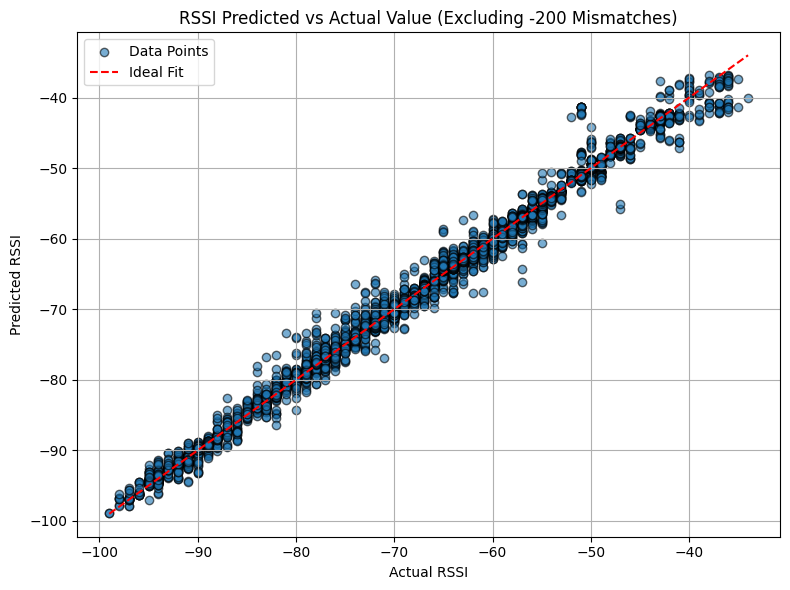

In [1235]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure y_test and y_pred_rssi are 1D arrays
combined_actual = y_test
combined_predicted = y_pred_rssi

mask = (combined_actual != -200) & (combined_predicted != -200)
combined_actual = combined_actual[mask]
combined_predicted = combined_predicted[mask]

# Create the scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(combined_actual, combined_predicted, alpha=0.6, edgecolors='k', label="Data Points")
plt.plot([combined_actual.min(), combined_actual.max()],
         [combined_actual.min(), combined_actual.max()], color='red', linestyle='--', label="Ideal Fit")
plt.title("RSSI Predicted vs Actual Value (Excluding -200 Mismatches)")
plt.xlabel("Actual RSSI")
plt.ylabel("Predicted RSSI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Genetic Algorithm

In [1227]:
import itertools
import pygad
import random

In [1228]:
filtered_data

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp,transmit_power,ap_x,ap_y
0,2024-10-17 08:38:31.952562400+00:00,1,3,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:38:31.952562,300,1368,26,867,1122
1,2024-10-17 08:39:38.608620600+00:00,1,1,DTE Staff,3,11,300,1368,-63.0,-200.0,0,08:39:38.608620,300,1367,30,867,1122
2,2024-10-17 08:39:45.832622300+00:00,1,1,DTE Student,4,11,300,1368,-63.0,-200.0,0,08:39:45.832622,300,1367,26,867,1122
3,2024-10-17 08:40:03.157448400+00:00,1,2,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:40:03.157448,300,1368,26,867,1122
5,2024-10-17 08:40:27.631585400+00:00,1,3,DTE Student,4,11,300,1368,-62.0,-200.0,0,08:40:27.631585,300,1368,26,867,1122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6514,2025-03-12 07:28:20.594572600+00:00,116,19,DTE Staff,3,6,1520,134,-72.0,-200.0,-1,07:28:20.594572,1520,139,30,867,1122
6515,2025-03-12 07:28:23.628276100+00:00,116,19,DTE Staff,2,11,1520,134,-200.0,-81.0,-1,07:28:23.628276,1520,134,20,2454,520
6516,2025-03-12 07:28:26.622391800+00:00,116,19,DTE Staff,1,11,1520,134,-200.0,-82.0,-1,07:28:26.622391,1520,133,23,2454,520
6519,2025-03-12 07:28:48.091094300+00:00,116,20,DTE Staff,2,11,1520,134,-200.0,-84.0,-1,07:28:48.091094,1520,134,20,2454,520


In [1229]:
df = filtered_data.drop(columns=['time','ssid','xr','yr','iteration'])

In [1230]:
# Define possible transmit power levels for each AP
power_levels = [20, 23, 26, 30]

# Genetic Algorithm Parameters
POPULATION_SIZE = 10
GENERATIONS = 10
MUTATION_RATE = 0.4
CROSSOVER_RATE = 0.7

# # Interference penalty threshold
# INTERFERENCE_THRESHOLD = -90  

In [1231]:
# Extract reference points (users) from dataframe
reference_points = df['reference_point'].unique()

In [1232]:
print("Sample Predicted RSSI Values:", y_pred_rssi[:10])

Sample Predicted RSSI Values: [[ -63.387512 -199.99905 ]
 [ -62.977386 -200.02089 ]
 [ -63.042248 -200.01924 ]
 [ -64.49323  -199.994   ]
 [ -63.387512 -199.99905 ]
 [ -63.439278 -199.99905 ]
 [ -62.862305 -200.00824 ]
 [ -63.29837  -199.98485 ]
 [ -62.6934   -199.9928  ]
 [ -63.84287  -200.05217 ]]


In [1233]:
import numpy as np
import pandas as pd
import random

# Define possible transmit power levels for each AP
power_levels = [20, 23, 26, 30]

# Genetic Algorithm Parameters
POPULATION_SIZE = 10
GENERATIONS = 5
MUTATION_RATE = 0.4
CROSSOVER_RATE = 0.7
TOURNAMENT_SIZE = 3  # For selection diversity

# Extract reference points (users) from dataframe
reference_points = data['reference_point'].unique()

# Function to predict RSSI for a given transmit power setting
def predict_rssi_for_power(transmit_power_combination):
    df_temp = data.copy()

    # Assign different transmit power levels to APs
    df_temp['transmit_power_ap_digilab'] = transmit_power_combination[0]
    df_temp['transmit_power_ap_dosen'] = transmit_power_combination[1]

    # Prepare feature set for prediction
    X_test = regression_data_scaled  # Only use valid numeric features
    y_pred = best_model.predict(X_test)  # Predict RSSI for given power

    # Create a DataFrame for predictions
    df_pred = pd.DataFrame(y_pred, columns=['pred_rssi_digilab', 'pred_rssi_dosen'])

    # Attach predictions to the dataframe
    df_temp[['pred_rssi_digilab', 'pred_rssi_dosen']] = df_pred

    return df_temp  # Return updated dataframe with predicted RSSI values

# Function to apply roaming based on predicted RSSI
def apply_roaming(df_temp):
    roaming_users = []
    ROAM_THRESHOLD = 3  # Only roam if new AP is significantly better

    def update_rssi(row):
        # Determine the currently connected AP
        if row['rssi_ap_digilab'] != -200:
            current_ap = 'digilab'
            other_ap = 'dosen'
            current_rssi = row['pred_rssi_digilab']
            other_rssi = row['pred_rssi_dosen']
        else:
            current_ap = 'dosen'
            other_ap = 'digilab'
            current_rssi = row['pred_rssi_dosen']
            other_rssi = row['pred_rssi_digilab']

        # Apply roaming decision
        if other_rssi > current_rssi + ROAM_THRESHOLD:
            row[f'rssi_ap_{current_ap}'] = -200  # Disconnect from previous AP
            row[f'rssi_ap_{other_ap}'] = other_rssi  # Connect to the new AP
            roaming_users.append(row['reference_point'])  # Log roaming event
        else:
            row[f'rssi_ap_{current_ap}'] = current_rssi  # Stay with current AP

        return row

    df_temp = df_temp.apply(update_rssi, axis=1)
    return df_temp, set(roaming_users)  # Return dataframe & roaming users set

# Function to evaluate fitness (Interference Removed)
def evaluate_fitness(transmit_power_combination):
    # Predict RSSI for the current transmit power settings
    df_updated = predict_rssi_for_power(transmit_power_combination)

    # Apply roaming logic
    df_updated, roaming_users = apply_roaming(df_updated)

    total_rssi_before = df[['rssi_ap_digilab', 'rssi_ap_dosen']].replace(-200, np.nan).sum().sum()
    total_rssi_after = df_updated[['rssi_ap_digilab', 'rssi_ap_dosen']].replace(-200, np.nan).sum().sum()

    max_rssi_before = max(df['rssi_ap_digilab'].max(), df['rssi_ap_dosen'].max())
    max_rssi_after = max(df_updated['rssi_ap_digilab'].max(), df_updated['rssi_ap_dosen'].max())

    # Fitness now rewards RSSI improvement
    fitness = (total_rssi_after - total_rssi_before) * 10 + (max_rssi_after - max_rssi_before) * 100

    return fitness, roaming_users, total_rssi_before, total_rssi_after, max_rssi_before, max_rssi_after

# Tournament Selection Function
def tournament_selection(population, fitness_scores, tournament_size=TOURNAMENT_SIZE):
    selected = random.sample(list(zip(fitness_scores, population)), tournament_size)  # Flip order
    selected.sort(key=lambda x: x[0], reverse=True)  # Sort by fitness (higher is better)
    return list(selected[0][1])  # Ensure it returns the selected individual's transmit power settings

# Function to perform crossover
def crossover(parent1, parent2):
    if not isinstance(parent1, list) or not isinstance(parent2, list):
        raise ValueError(f"Crossover Error: Expected lists but got {type(parent1)} and {type(parent2)}")
    
    if random.random() < CROSSOVER_RATE:
        return [parent1[0], parent2[1]], [parent2[0], parent1[1]]  # Swap one power level
    return parent1, parent2

# Function to perform mutation
def mutate(individual):
    if random.random() < MUTATION_RATE:
        mutate_index = random.randint(0, 1)
        individual[mutate_index] = random.choice([p for p in power_levels if p != individual[mutate_index]])
    return individual

# Function to initialize population with diverse power levels
def initialize_population():
    return [random.sample(power_levels, 2) for _ in range(POPULATION_SIZE)]

# Main Genetic Algorithm Loop
population = initialize_population()
best_fitness_history = []

for generation in range(GENERATIONS):
    fitness_scores = []
    
    # Evaluate fitness for each individual
    for individual in population:
        fitness, roaming_users, total_rssi_before, total_rssi_after, max_rssi_before, max_rssi_after = evaluate_fitness(individual)
        fitness_scores.append((fitness, individual, roaming_users, total_rssi_before, total_rssi_after, max_rssi_before, max_rssi_after))

    # Sort population by fitness (descending order)
    fitness_scores.sort(reverse=True, key=lambda x: x[0])
    best_individual = fitness_scores[0][1]
    best_fitness_history.append(fitness_scores[0][0])

    # Print the results
    print(f"\nGeneration {generation + 1}:")
    print(f"Best Transmit Power: {best_individual}")
    print(f"Fitness: {fitness_scores[0][0]}")
    print(f"Roaming Users: {len(fitness_scores[0][2])}, Reference Points That Roamed: {fitness_scores[0][2]}")
    print(f"Total RSSI Before: {fitness_scores[0][3]:.2f}, After: {fitness_scores[0][4]:.2f}")
    print(f"Max RSSI Before: {fitness_scores[0][5]:.2f}, After: {fitness_scores[0][6]:.2f}")

    # Selection using tournament selection instead of always keeping the best
    new_population = [tournament_selection(population, [x[0] for x in fitness_scores]) for _ in range(POPULATION_SIZE//2)]


    # Crossover & Mutation to generate new individuals
    while len(new_population) < POPULATION_SIZE:
        parent1, parent2 = random.sample(new_population, 2)
        child1, child2 = crossover(parent1, parent2)
        new_population.append(mutate(child1))
        new_population.append(mutate(child2))

    # Update population
    population = new_population

# Best transmit power combination after all generations
print(f"\nOptimal Transmit Power: {best_individual}")



Generation 1:
Best Transmit Power: [20, 23]
Fitness: 20092.051849365234
Roaming Users: 76, Reference Points That Roamed: {4, 5, 6, 9, 10, 11, 16, 17, 18, 19, 20, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 63, 64, 66, 67, 68, 69, 70, 71, 72, 75, 76, 77, 80, 81, 82, 85, 88, 89, 90, 93, 95, 98, 99, 100, 103, 104, 105, 108, 109, 113, 114, 115, 118, 119, 120}
Total RSSI Before: -371678.00, After: -369640.92
Max RSSI Before: -34.00, After: -36.79

Generation 2:
Best Transmit Power: [26, 20]
Fitness: 20092.051849365234
Roaming Users: 76, Reference Points That Roamed: {4, 5, 6, 9, 10, 11, 16, 17, 18, 19, 20, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 63, 64, 66, 67, 68, 69, 70, 71, 72, 75, 76, 77, 80, 81, 82, 85, 88, 89, 90, 93, 95, 98, 99, 100, 103, 104, 105, 108, 109, 113, 114, 115, 118, 119, 120}
Total RSSI Before: -371678.00, After: -369